In [1]:
import sys
import os

# # Go up two levels to reach the project root and add it to the path
sys.path.append(os.path.abspath("../"))

In [2]:
from src.loader.load_dataset import load_all_matfiles
df = load_all_matfiles(channels=['vibration_1'])

df.head()


Processing ../dataset/paderborn-db: 0it [00:00, ?it/s]
Processing ../dataset/paderborn-db/KA08:  50%|█████     | 40/80 [00:09<00:08,  4.70it/s]

Error loading ../dataset/paderborn-db/KA08/N15_M01_F10_KA08_2.mat: Expecting matrix here


Processing ../dataset/paderborn-db/KI04: 100%|██████████| 80/80 [00:11<00:00,  7.12it/s]

Skipped 1 files.


,bearing_id,torque_nm,speed_rpm,radial_force_n,label,vibration_1_time_rms,vibration_1_time_kurtosis,vibration_1_time_skewness,vibration_1_time_crest_factor,vibration_1_time_peak_to_peak,vibration_1_time_std_dev,vibration_1_freq_rms,vibration_1_freq_kurtosis,vibration_1_freq_skewness,vibration_1_freq_crest_factor,vibration_1_freq_peak_to_peak,vibration_1_freq_std_dev
0,KA01,0.7,1500,400,1,0.518003,19.384970,1.903199,11.735645,10.336304,0.517786,262.201800,22.487747,4.009773,14.635092,3837.260699,222.507888
1,KA01,0.7,900,1000,1,0.227813,12.999637,1.132015,11.413290,4.809570,0.227321,115.514440,58.844795,4.993217,33.179609,3832.561720,86.931825
2,KA01,0.7,1500,400,1,0.521671,19.586672,1.982920,10.863386,9.588623,0.521458,264.055657,21.444264,3.921185,14.444069,3813.872356,223.515873
3,KA01,0.7,1500,400,1,0.520496,19.800676,1.984644,11.398000,9.835815,0.520280,263.497885,27.815165,4.282769,18.128254,4776.540945,224.326663
4,KA01,0.7,1500,1000,1,0.540600,11.751166,0.698111,7.270924,7.778931,0.540341,273.655598,43.329350,5.450250,17.744486,4855.822172,238.999835


In [3]:
# Show data distribution
df['label'].value_counts()

label
1    959
2    880
0    480
3    240
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop(['label', 'bearing_id', 'torque_nm', 'speed_rpm', 'radial_force_n'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)


smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)



print(y_train.value_counts())
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

label
2    767
0    767
1    767
3    767
Name: count, dtype: int64
X_train shape: (3068, 12)
y_train shape: (3068,)
X_test shape: (512, 12)
y_test shape: (512,)


## Training

In [5]:
# Random Forest
from src.models.randomforest_model import RandomForestModel

rf = RandomForestModel(random_state=42)
rf.train(X_train, y_train)
y_pred = rf.predict(X_test)



## Evaluation

### Classification Report and Cohen’s Kappa Score

In [6]:
from sklearn.metrics import classification_report, cohen_kappa_score
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Cohen's Kappa Score:")
print(cohen_kappa_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        96
           1       0.98      0.99      0.99       192
           2       0.96      0.95      0.96       176
           3       0.94      0.98      0.96        48

    accuracy                           0.97       512
   macro avg       0.97      0.97      0.97       512
weighted avg       0.97      0.97      0.97       512

Cohen's Kappa Score:
0.9579795150135691


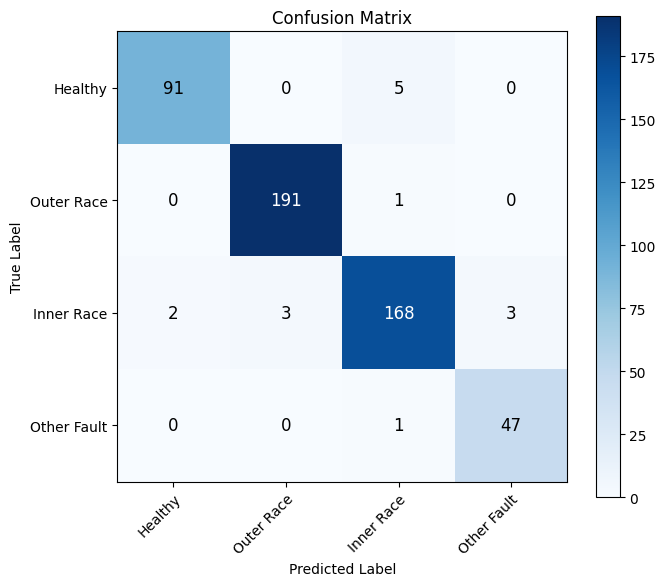

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Example: your predicted and true labels
# y_test, y_pred

# Define class names
class_names = ['Healthy', 'Outer Race', 'Inner Race', 'Other Fault']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set ticks and labels
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True Label',
    xlabel='Predicted Label',
    title='Confusion Matrix'
)

# Rotate x-axis labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color=color, fontsize=12)

plt.tight_layout()
plt.show()


### ROC Cuve

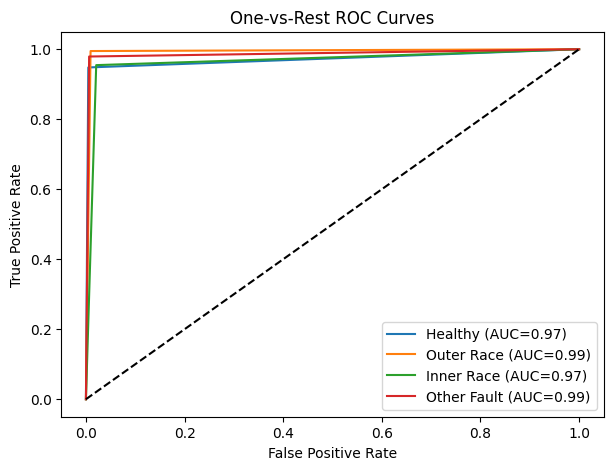

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = label_binarize(y_pred, classes=np.arange(n_classes))

plt.figure(figsize=(7,5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("One-vs-Rest ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### Precision - Recall Curve

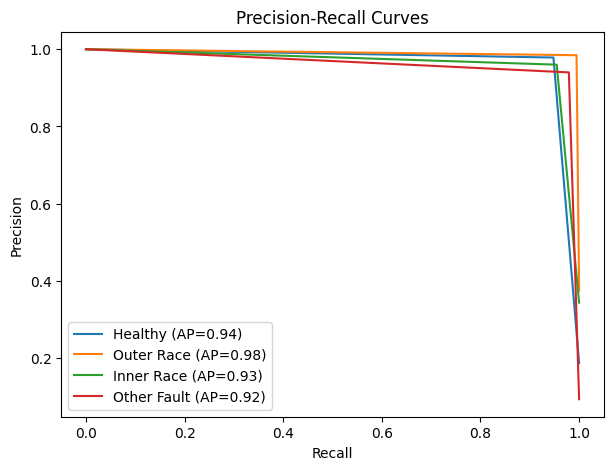

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap:.2f})")

plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


### Feature Importance

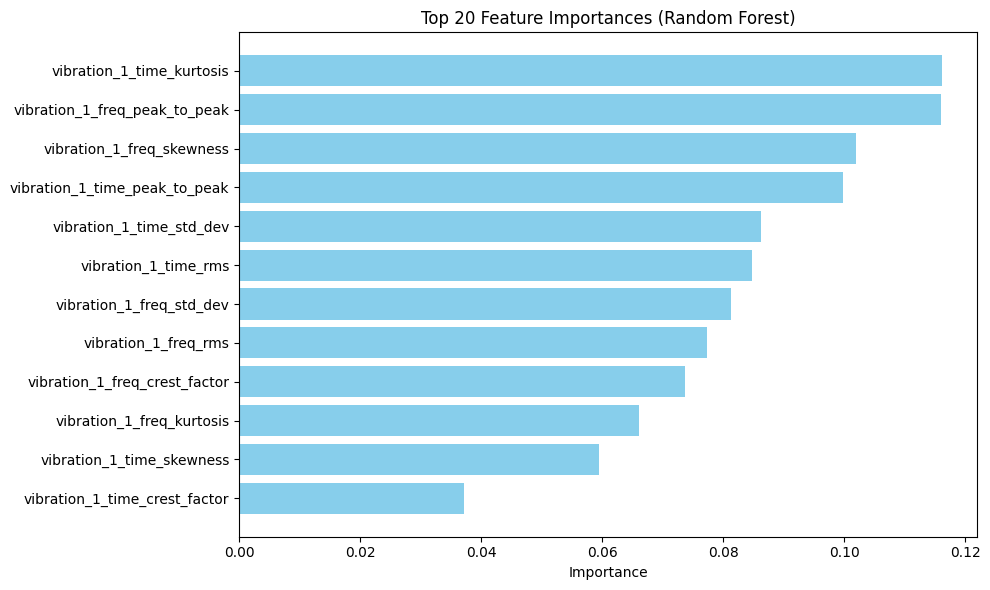

In [10]:
# Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importance from your trained RF model
importances = rf.model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for easy plotting
feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20 features
top_n = 20
plt.figure(figsize=(10,6))
plt.barh(feat_df['feature'].head(top_n)[::-1], feat_df['importance'].head(top_n)[::-1], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


## Export Model For Future  use

In [ ]:
# export model
path = "expo"
rf.export("../exports/models.joblib")